In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy, Precision, Recall
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 64
dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=batch_size, shuffle=False)

num_classes = len(train_data.classes)
image_size = train_data[0][0].shape[1]

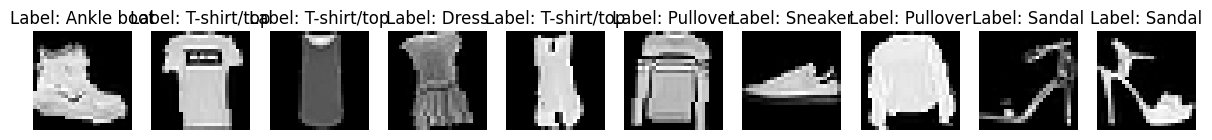

In [6]:
def show_sample_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {train_data.classes[label]}")
        axes[i].axis("off")
    plt.show()

show_sample_images(train_data)


In [7]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (image_size // 4) ** 2, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [8]:
def train_model(net, dataloader_train, optimizer, num_epochs):
    net.to(device)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                pbar.set_postfix(loss=running_loss / len(dataloader_train), acc=100 * correct / total)

        epoch_loss = running_loss / len(dataloader_train)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    print("Training complete!")
    return train_losses, train_accuracies


In [9]:
net = ImprovedCNN(num_classes).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_losses, train_accuracies = train_model(
    net=net,
    dataloader_train=dataloader_train,
    optimizer=optimizer,
    num_epochs=10
)


Epoch 1/10: 100%|██████████| 938/938 [00:15<00:00, 61.67it/s, acc=81.8, loss=0.494] 


Epoch [1/10] - Loss: 0.4942, Accuracy: 81.80%


Epoch 2/10: 100%|██████████| 938/938 [00:17<00:00, 53.71it/s, acc=86.3, loss=0.369] 


Epoch [2/10] - Loss: 0.3691, Accuracy: 86.30%


Epoch 3/10: 100%|██████████| 938/938 [00:17<00:00, 52.48it/s, acc=87.6, loss=0.333] 


Epoch [3/10] - Loss: 0.3329, Accuracy: 87.61%


Epoch 4/10: 100%|██████████| 938/938 [00:18<00:00, 51.82it/s, acc=88.6, loss=0.308] 


Epoch [4/10] - Loss: 0.3080, Accuracy: 88.58%


Epoch 5/10: 100%|██████████| 938/938 [00:18<00:00, 51.90it/s, acc=89.1, loss=0.295] 


Epoch [5/10] - Loss: 0.2953, Accuracy: 89.08%


Epoch 6/10: 100%|██████████| 938/938 [00:18<00:00, 51.73it/s, acc=89.6, loss=0.281] 


Epoch [6/10] - Loss: 0.2809, Accuracy: 89.55%


Epoch 7/10: 100%|██████████| 938/938 [00:17<00:00, 52.24it/s, acc=89.9, loss=0.27]  


Epoch [7/10] - Loss: 0.2705, Accuracy: 89.89%


Epoch 8/10: 100%|██████████| 938/938 [00:18<00:00, 51.77it/s, acc=90.2, loss=0.264] 


Epoch [8/10] - Loss: 0.2643, Accuracy: 90.20%


Epoch 9/10: 100%|██████████| 938/938 [00:18<00:00, 51.64it/s, acc=90.6, loss=0.254] 


Epoch [9/10] - Loss: 0.2536, Accuracy: 90.61%


Epoch 10/10: 100%|██████████| 938/938 [00:18<00:00, 51.60it/s, acc=90.8, loss=0.247] 

Epoch [10/10] - Loss: 0.2466, Accuracy: 90.79%
Training complete!


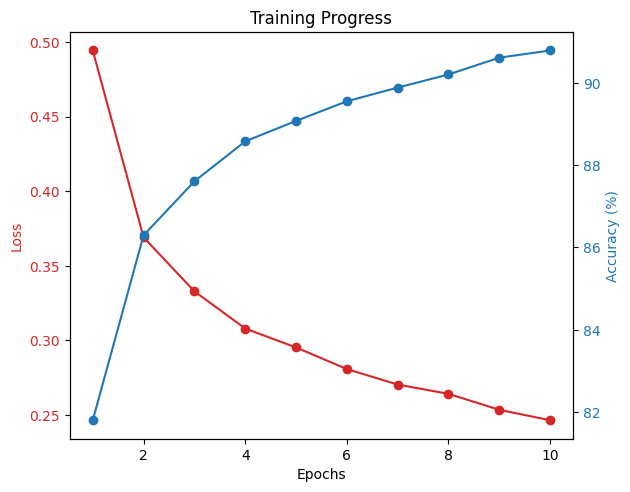

In [10]:
def plot_training_progress(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, losses, color='tab:red', marker='o', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:blue')
    ax2.plot(epochs, accuracies, color='tab:blue', marker='o', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title("Training Progress")
    plt.show()

plot_training_progress(train_losses, train_accuracies)


In [11]:
def evaluate_model(net, dataloader_test):
    net.to(device)
    net.eval()

    accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes).to(device)
    precision_metric = Precision(task='multiclass', num_classes=num_classes, average='macro').to(device)
    recall_metric = Recall(task='multiclass', num_classes=num_classes, average='macro').to(device)

    correct = 0
    total = 0
    predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader_test, desc="Evaluating Model"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = net(images)
            predicted = torch.argmax(outputs, dim=1)
            predictions.extend(predicted.tolist())

            accuracy_metric.update(predicted, labels)
            precision_metric.update(predicted, labels)
            recall_metric.update(predicted, labels)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = accuracy_metric.compute().item()
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision (macro avg): {precision:.4f}')
    print(f'Recall (macro avg): {recall:.4f}')

evaluate_model(net, dataloader_test)


Evaluating Model: 100%|██████████| 157/157 [00:02<00:00, 65.17it/s]


Accuracy: 0.9177
Precision (macro avg): 0.9176
Recall (macro avg): 0.9177


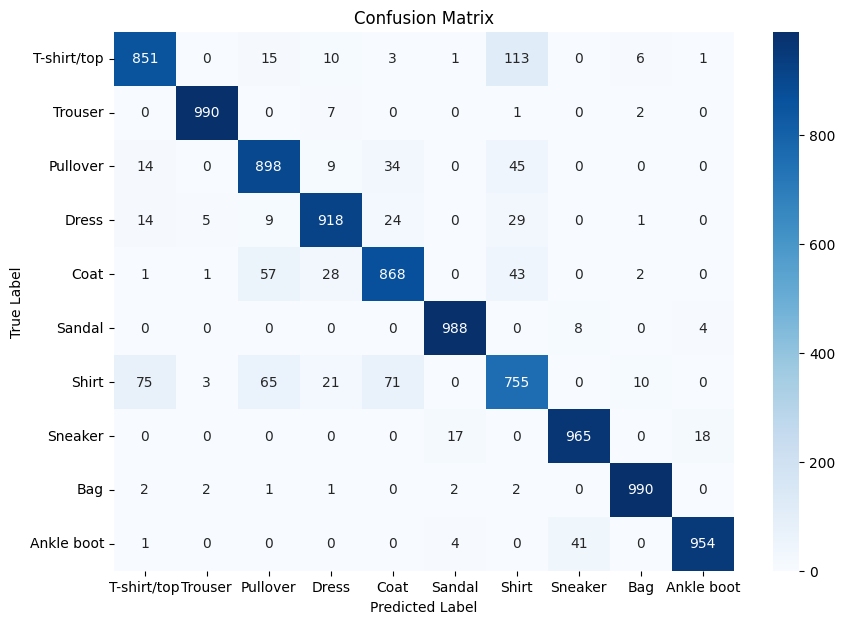

In [13]:
def plot_confusion_matrix(net, dataloader_test):
    net.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = torch.argmax(outputs, dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Now run the confusion matrix plot
plot_confusion_matrix(net, dataloader_test)
